In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# Load one training sample

In [2]:
train_path = "./train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[0], 'rb') as f:
    training_sample = pickle.load(f)

In [3]:
# There are at most 60 agents/vehicles in a scene
# 'agent_id' is the track id for the agent to be predicted in this scene
training_sample.keys()

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'p_out', 'v_out', 'track_id'])

In [4]:
training_sample['agent_id']

'00000000-0000-0000-0000-000000044289'

In [5]:
training_sample['p_in'].shape

(60, 19, 2)

In [6]:
training_sample['lane'].shape

(216, 2)

In [25]:
scene = training_sample
# the index of agent to be predicted 
pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
print(pred_id, "pred_id")
print(scene['car_mask'], "scene[car_mask]", scene['car_mask'].shape)
valid_p_ins = scene['p_in'][np.where(scene['car_mask'] == 1)[0]]
valid_v_ins = scene['v_in'][np.where(scene['car_mask'] == 1)[0]]
valid_p_outs = scene['p_out'][np.where(scene['car_mask'] == 1)[0]]
valid_v_outs = scene['v_out'][np.where(scene['car_mask'] == 1)[0]]
print(valid_p_ins, "valid_p_ins",valid_p_ins.shape)
print(valid_v_ins, "valid_v_ins",valid_v_ins.shape)
# input: p_in & v_in; output: p_out
inp_scene = np.dstack([valid_p_ins, valid_v_ins])
out_scene = np.dstack([valid_p_outs, valid_v_outs])
print(inp_scene, "inp_scene", inp_scene.shape)
print(out_scene, "out_scene", out_scene.shape)
# Normalization 
print(valid_p_outs.shape,valid_p_ins.shape)
all_ps = np.concatenate((valid_p_ins,valid_p_outs),axis=1)
print(all_ps.shape)
all_ps = np.dstack([all_ps,all_ps])
print(all_ps.shape)
min_vecs = np.min(inp_scene, axis = (0,1))
max_vecs = np.max(inp_scene, axis = (0,1))
# min_vecs = np.min(all_ps, axis = (0,1))
# max_vecs = np.max(all_ps, axis = (0,1))
print(min_vecs, "min_vecs")
print(max_vecs, "max_vecs")
# Normalize by vectors
inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)

9 pred_id
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] scene[car_mask] (60, 1)
[[[2176.23144531  718.4175415 ]
  [2176.23168945  718.41748047]
  [2176.23217773  718.41778564]
  [2176.23266602  718.41766357]
  [2176.23291016  718.41809082]
  [2176.2331543   718.41802979]
  [2176.23413086  718.41845703]
  [2176.23657227  718.42034912]
  [2176.23828125  718.42169189]
  [2176.24755859  718.42980957]
  [2176.27392578  718.45214844]
  [2176.29760742  718.47235107]
  [2176.33862305  718.50708008]
  [2176.38452148  718.54650879]
  [2176.44628906  718.59887695]
  [2176.51611328  718.65814209]
  [2176.59985352  718.72918701]
  [2176.69702148  718.81158447]
  [2176.81640625  718.9119262

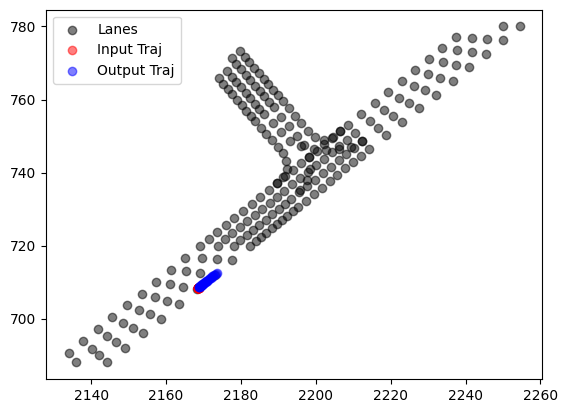

In [22]:
plt.scatter(training_sample['lane'][:,0], training_sample['lane'][:,1], alpha=0.5, label = "Lanes", color = "black")

plt.scatter(training_sample['p_in'][1,:,0], training_sample['p_in'][1,:,1], alpha=0.5, label = "Input Traj", color = "red")
plt.scatter(training_sample['p_out'][1,:,0], training_sample['p_out'][1,:,1], alpha=0.5, label = "Output Traj", color = "blue")
       
plt.legend()
# plt.xticks([])
# plt.yticks([])
plt.show()

# Examining the submission format

In [14]:
test_path = "./val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()
with open(test_pkl_list[0], 'rb') as f:
    test_sample = pickle.load(f)

In [15]:
test_sample.keys()

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'track_id'])

In [18]:
test_sample['p_in'].shape

(60, 19, 2)

In [19]:
# Submission Files: a sample submission file in the correct format
# 30-step ahead predictions of positions. 
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
predictions = np.random.randn(3200, 60)

In [21]:
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1,61)]]])
sub_df.to_csv('test_submission.csv', index=None)